### IS - Brand position
Finding Product position on Social Network (PPSN)

In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import itertools
import math
import string
import json
import pymongo
from itertools import groupby

In [2]:
import gensim
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

from pythainlp.corpus import thai_stopwords

# Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=pd.core.common.SettingWithCopyWarning)

C:\ProgramData\Anaconda3\lib\site-packages\past\types\oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable
C:\ProgramData\Anaconda3\lib\site-packages\_pytest\mark\structures.py:378: DeprecationWarning: The usage of `cmp` is deprecated and will be removed on or after 2021-06-01.  Please use `eq` and `order` instead.
  @attr.s(cmp=False, hash=False)


In [3]:
# Connect MongoDB
myclient = pymongo.MongoClient("mongodb://localhost:27017/")
mydb = myclient["NIDA_PPSN_PRD"]
col_thread = mydb["NIDA_PPSN_THREAD"]
col_comment = mydb["NIDA_PPSN_COMMENT"]

In [4]:
def reduced_keyword(wtkn,redCol):
    del_list = []
    ret_wtkn = wtkn
    for each in ret_wtkn:
        if each not in redCol:
            del_list.append(each)
    ret_wtkn = [x for x in ret_wtkn if x not in del_list]
    return ret_wtkn

### 3.Process หัวกระทู้เพื่อดึง Domain (Brand & Product) ไม่ใช้โมเดลเทรนแล้วทำนาย ต้องการความถูกต้อง 100%

In [5]:
cursor_thread = col_thread.find()
df_thr_process = pd.DataFrame(cursor_thread)

In [6]:
cursor_comment = col_comment.find()
df_cmt_process = pd.DataFrame(cursor_comment)

In [7]:
# จริงๆต้องใช้เงื่อนไข t_mention_brand.str.len() != 0 และ t_mention_dairy.str.len() != 0
df_urls_milk = df_thr_process[(df_thr_process.t_mention_brand.str.len() != 0) | (df_thr_process.t_mention_dairy.str.len() != 0)]
df_urls_milk['t_mention_brand'] = df_urls_milk['t_mention_brand'].apply(lambda x: repr(set(x)))
df_urls_milk['t_mention_product'] = df_urls_milk['t_mention_product'].apply(lambda x: repr(set(x)))

In [8]:
df_join_url = pd.merge(df_urls_milk,df_cmt_process,how='inner',on='URLs')

In [9]:
df_join_url.drop(columns=['_id_x','_id_y','headline_x'],inplace=True)

In [10]:
#df_join_url = pd.merge(df_urls_milk,df_cmt_process,how='inner',on='URLs')
#df_join_url.drop(columns=['_id_x','_id_y','headline_x'],inplace=True)
df_join_url.columns = ['URLs','token_headline','t_mention_dairy','t_mention_product','t_mention_brand'
                       ,'commentId','headline','text','Retrived_date','token_text','cmt_mention_dairy'
                       ,'cmt_mention_product','cmt_mention_brand']

In [11]:
df_join_url.head(3)

,URLs,token_headline,t_mention_dairy,t_mention_product,t_mention_brand,commentId,headline,text,Retrived_date,token_text,cmt_mention_dairy,cmt_mention_product,cmt_mention_brand
0,https://pantip.com/topic/39868603,"[นม, เมจิ, รสหวาน, หายาก]",[นม],{'รสหวาน'},{'เมจิ'},1,นมเมจิรสหวานทำไมหายากจังคะ,เมื่อก่อนหลายปีมาแล้ว ในเซเว่นยังมีนมเมจิรสหวา...,2020-11-29 00:13:26.571,"[ปี, 7-Eleven, ยังมี, นม, เมจิ, รสหวาน, ขาย, อ...","[นม, นม]","[รสหวาน, รสหวาน]",[เมจิ]
1,https://pantip.com/topic/39868603,"[นม, เมจิ, รสหวาน, หายาก]",[นม],{'รสหวาน'},{'เมจิ'},2,นมเมจิรสหวานทำไมหายากจังคะ,เบาหวานครับ แฮ่ๆ,2020-11-29 00:13:26.571,"[เบาหวาน, แฮ่]",[],[],[]
2,https://pantip.com/topic/39868603,"[นม, เมจิ, รสหวาน, หายาก]",[นม],{'รสหวาน'},{'เมจิ'},3,นมเมจิรสหวานทำไมหายากจังคะ,หาซื้อไม่ได้นี่คิดได้ 2 อย่างนะ. คนไม่ค่อย...,2020-11-29 00:13:26.571,"[หาซื้อไม่ได้นี่คิดได้, , คน, กินกัน, ทำ, คน, ...",[],[รสหวาน],[]


EDA#2

จาก Issue นี้จะพบว่าทำ Product position ได้ยาก แต่ทำ Brand position แทนได้ เนื่องจากสัดส่วนของข้อความที่มีการพูดถึง brand+flavor 
มีน้อยกว่าครึ่ง จึงให้ใช้วิธีเอา brand ของหัวกระทู้แปะไปในทุก comment แทน เพื่อทำ Brand Position ส่วน flavor จะกลายเป็น attribute ไป

###  4. (ยกเลิกแต่เก็บ code) คัดเลือกคำมาเป็น Attribute ด้วย TF-IDF

In [12]:
#import gensim
#from gensim.models import TfidfModel

In [13]:
# Create Bag of Word & calculate TF-IDF
#dictionary = gensim.corpora.Dictionary(df_join_url['token_text'])
#gensim_corpus = [dictionary.doc2bow(text, allow_update=True) for text in df_join_url['token_text']]
#model = TfidfModel(gensim_corpus)
#vector = model[gensim_corpus]
#word_frequencies = [[(dictionary[id], tfidf_val) for id, tfidf_val in couple] for couple in vector]

In [14]:
#for i in range(0,len(word_frequencies)):
#    word_frequencies[i].sort(key=lambda tup:(-tup[1], tup[0]))  # SORT LIST of TUPLE DESCENDINGLY
#    word_frequencies[i] = word_frequencies[i][:10]   

In [15]:
# List complehension : get the first element of each tuple in a list
# https://www.kite.com/python/answers/how-to-get-the-first-element-of-each-tuple-in-a-list-in-python
#first_tuple_elements = [[a for a,tf in couple] for couple in word_frequencies]

In [16]:
#first_tuple_elements

### 4. คัดเลือกคำมาเป็น Attribute ด้วย LDAvis

https://radimrehurek.com/gensim/models/ldamodel.html

In [17]:
# Create Bag of Word & calculate TF-IDF
dictionary = gensim.corpora.Dictionary(df_join_url['token_text'])
gensim_corpus = [dictionary.doc2bow(text, allow_update=True) for text in df_join_url['token_text']]

In [18]:
num_topics = 8
chunksize = 4000     # size of the doc looked at every pass
iterations = 25      # Maximum number of iterations through the corpus when inferring the topic distribution of a corpus
eval_every = 1       # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

%time model = gensim.models.LdaModel(corpus=gensim_corpus, id2word=id2word, chunksize=chunksize \
                                     ,alpha='auto', eta='auto',iterations=iterations \
                                     ,num_topics=num_topics \
                                     ,eval_every=eval_every)

Wall time: 7.86 s


In [19]:
pyLDAvis.gensim.prepare(model, gensim_corpus, dictionary, R=40, lambda_step=0.05)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.032524  0.057339       1        1  21.665144
6      0.033445  0.033037       2        1  19.193833
5     -0.080954  0.041095       3        1  17.997075
1     -0.006503  0.029557       4        1  12.744101
0      0.054830 -0.024232       5        1  10.254837
4      0.061837  0.034644       6        1   8.080502
3      0.048586 -0.078790       7        1   5.404984
2     -0.078718 -0.092652       8        1   4.659523, topic_info=            Term         Freq        Total Category  logprob  loglift
23                4090.000000  4090.000000  Default  40.0000  40.0000
125  ไทยเดนมาร์ค   748.000000   748.000000  Default  39.0000  39.0000
7             นม  4941.000000  4941.000000  Default  38.0000  38.0000
989          แม่  1223.000000  1223.000000  Default  37.0000  37.0000
256        กล่อง  1333.000000  1333.000000  Default  36.0000  36.0000
..           ...          ...          ...      ...      ...      ...
6             คน    30.975143  1230.310924   Topic8  -5.5407  -0.6156
4            ขาย    28.377219   643.734878   Topic8  -5.6283  -0.0554
72        ไม่ได้    29.499272  1222.946982   Topic8  -5.5895  -0.6584
548        ไม่มี    26.308955   597.639279   Topic8  -5.7040  -0.0568
29            ทำ    26.570147  1259.113890   Topic8  -5.6941  -0.7921

[836 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
23        1  0.371860      
23        2  0.108795      
23        3  0.093637      
23        4  0.187274      
23        5  0.090948      
...     ...       ...   ...
3760      3  0.064040  ไวท์
3760      4  0.768475  ไวท์
502       1  0.866318    ไฮ
4238      2  0.897343   ๆจน
2668      7  0.782636   ๆผม

[2277 rows x 3 columns], R=40, lambda_step=0.05, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 7, 6, 2, 1, 5, 4, 3])

### ทำ WordCloud เพื่ออธิบายแต่ละกลุ่มว่าเกี่ยวกับอะไร

In [20]:
cloud = WordCloud(font_path='thsarabunnew-webfont.ttf',background_color='white',max_words=40)

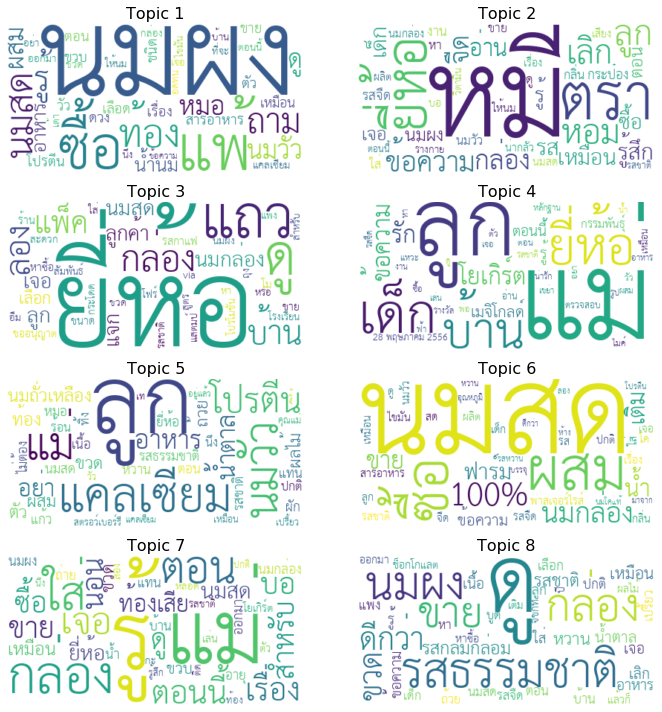

In [22]:
# REF: https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/
topics = model.show_topics(num_topics=8, num_words=300,formatted=False)

# ตัดเศษคำหรือเทอมที่ไม่ต้องการออกก่อน (บางตัวเป็นชื่อแบรนด์ stopword หรือ Strong Ties)
rem = {'กิน','กินนม','ทาน','อร่อย','ชอบ','ออ','ดื่ม','ดื่มนม','ขอบคุณ','นม','ดูด','ทำ','//','ริ','หล่อ','แบบนี้','อาทิตย์','สัปดาห์'
       ,' ','','ดี','ผม','คน','เค้า','กระทู้','เหมือนกัน','อ่ะ','คลิก','ที่ซ่อน','pantipcom','พี่','ไม่ได้','ไม่มี'
       ,'ไทย','เดนมาร์ค','เดนมาร์ก','ดัชมิลล์','เมจิ','โฟร์โมสต์','โชคชัย','เวลา'
       ,'แดรี่โฮม','เอ็มมิลค์','แมคโนเลีย','ไทยเดนมาร์ค','หนองโพ','คาเนชั่น','บีทาเก้น','จิตรลดา'
       ,'tops','makro','lotus','bigc','7-Eleven'}
th_stopwords = set(thai_stopwords()).union(rem)
minProb = 0.001
maxProb = 0.01

fig, axes = plt.subplots(4, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = {a: b for a, b in topics[i][1] if a not in th_stopwords and (b >= minProb and b <= maxProb)}
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud,interpolation='bilinear',cmap=plt.cm.gray)
    plt.gca().set_title('Topic ' + str(i+1), fontdict=dict(size=16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

### Export คำไปคัดเลือกอย่างละเอียด

สรุปคำที่จะนำมาเป็น Attribute (รวม link ที่เป็นเคสยกเว้น)

In [23]:
execption_urls = ['https://pantip.com/topic/30833944','https://pantip.com/topic/30105850','https://pantip.com/topic/35439062']

In [24]:
attrributes = ['เก็บรักษา','เข้มข้น','เค้ก','เจมส์','เจมส์ จิ','เจมส์จิ','เจลลาติน','เจือจาง','เชื้อ','เชื้อโรค','เชื้อจุลินทรีย์','เชื้อรา','เด็ก','เด็กเล็ก','เด็กแรกเกิด'
               ,'เด็กโต','เด็กชาย','เด็กทารก','เด็กน้อย','เด็กวัยรุ่น','เด็กอ่อน','เติบโต','เตี้ย','เนย','เนยแข็ง','เนยสด','เนสเล่','เนสกาแฟ','เนสท์เล่','เน่า','เน่าเสีย'
               ,'เบาหวาน','เมจิ','เมจิโกลด์','เมจิบัลแกเรีย','เมล่อน','เย็น','เล่นเวท','เล่นกล้าม','เลี้ยง','เลี้ยงเด็ก','เลี้ยงดู','เลี้ยงลูก','เลี้ยงสัตว์','เวย์','เวย์โปรตีน'
               ,'เหม็นเขียว','เหม็นเปรี้ยว','เหม็นคาว','เหม็นบูด','เอนไซม์','เอ็นไซม์','เอนฟาโกร','เอ็มมิลค์','เอสเปรสโซ','เอสเปรสโซ่','เอสเพรสโซ','เอสเพรสโซ่'
               ,'แข็งแรง','แคนตาลูป','แคลเซียม','แคลเซี่ยม','แคลอรี','แคลอรี่','แจก','แช่เย็น','แชร์','แดรี่โฮม','แตงโม','แถม','แบคทีเรีย','แบบสอบถาม','แพ็ก'
               ,'แพกเกจ','แพ็กเกจ','แพ็ค','แพ๊ค','แพคเกจ','แพ็คเกจ','แพคคู่','แพ้ท้อง','แพ้นม','แพ้นมวัว','แม่','แมกนีเซียม','แมคโนเลีย','แม่ลูกอ่อน','แร่ธาตุ'
               ,'แลกโตส','แล็กโต๊ส','แลคโตส','แลคติก','แอโรบิค','แอนตี้ไบโอติก','แอปเปิล','แอปเปิ้ล','โกโก้','โฆษณา','โชคชัย','โซเดียม','โด้บ','โด๊บ','โด้ป'
               ,'โด๊ป','โด้ปนม','โปรโมชั่น','โปรตีน','โพแทสเซียม','โฟเลต','โฟร์โมสต์','โฟลิค','โภชนาการ','โยเกิร์ต','โยเกิร์ท','โรคเบาหวาน','โรคกระเพาะ'
               ,'โรคขาดอาหาร','โรคท้องร่วง','โรคประจำตัว','โรคภัยไข้เจ็บ','โรคภูมิแพ้','โรคมะเร็ง','โรคหัวใจ','โรงเรียน','โรงงาน','โอวัลติน','ให้นม','ให้อาหาร'
               ,'ไขมัน','ไขมัน 0%','ไขมันต่ำ','ไทยเดนมาร์ค','ไอติม','ไอศกรีม','ไอศครีม','ไฮโปรตีน','กรดไขมัน','กรดอะมิโน','กระดูกพรุน','กระบวนการผลิต'
               ,'กระป๋อง','กล้วย','กล้วหอม','กล่อง','กลิ่น','กลิ่นคาว','กลิ่นหอม','กลูโคส','กาเฟอีน','กาแฟ','กาแฟเย็น','กาแฟร้อน','กาแฟสด','การบรรจุ'
               ,'การผลิต','การย่อยอาหาร','การลดน้ำหนัก','การลดราคา','การออกกำลังกาย','ข้น','ขนม','ขนมเค้ก','ขนมปัง','ขนมปังแผ่น','ขนมหวาน','ขนส่ง'
               ,'ขวดโหล','ขวดนม','ขวบ','ขาดตลาด','ขายไม่ดี','ขายไม่ออก','ขายปลีก','ขายส่ง','ข้าว','ข้าวโพด','ข้าวโอ๊ต','ข้าวกล้อง','คนรุ่นใหม่','คนวัยหนุ่มสาว'
               ,'คนสูงอายุ','ครรภ์','คลอเรสเตอรอล','คลอเลสเตอรอล','คลอโรฟิล','คลอดลูก','ความคุ้มค่า','ความมัน','ความร้อน','คอเลสเตอรอล','คาเฟอีน','ค่าขนส่ง'
               ,'คาปูชิโน','คาปูชิน่','คาร์โบไฮเดรต','คาราเมล','คาว','คุณแม่','คุณแม่มือใหม่','คุณค่า','คุณประโยชน์','คุณภาพ','คุณภาพดี','ฆ่าเชื้อ','จิตรลดา','จืด'
               ,'จุลินทรีย์','ฉลาก','ชง','ชงนม','ช็อกโกแลต','ช่องแช่แข็ง','ชอบ','ชา','ชาเขียว','ชาเขียวมัจฉะ','ชาเย็น','ชิม','ซื้อ','ซุปเปอร์มาร์เกต','ซุปเปอร์มาร์เก็ต'
               ,'ดัมิลล์','ดาร์คช็อกโกแลต','ต้ม','ตลาด','ตัวแทนจำหน่าย','ตู้เย็น','ท้องเสีย','ท้องตลาด','ท้องร่วง','ท้องว่าง','ท้องอืด','ทุเรียน','ธรรมชาติ','ธัญญาหาร'
               ,'ธัญพืช','ธาตุเหล็ก','นม','นมเปรี้ยว','นมกล่อง','นมข้น','นมข้นหวาน','นมควาย','นมถั่วเหลือง','นมผง','นมฟรีแลคโตส','นมยูเอชที','นมวัว','นมสด'
               ,'นมฮอกไกโด','นอน','น้ำ','นำเข้า','น้ำเชื่อม','น้ำเต้าหู้','น้ำตาล','น้ำตาลเทียม','น้ำตาลทราย','น้ำตาลทรายแดง','น้ำนม','น้ำผึ้ง','น้ำหนัก','บรรจุขวด'
               ,'บลูเบอร์รี่','บัลแกเรีย','บัลกาเรีย','บาริสตา','บาริสต้า','บีทาเก้น','บูด','ปริมาณ','ปลอดเชื้อ','ปวดท้อง','ปั่น','ผลไม้','ผสม','ผู้จัดจำหน่าย','ผู้ผลิต','ฝา'
               ,'พกพา','พนักงานขายนม','พลังงาน','พาราไดซ์','พารากอน','พาสเจอร์ไรส์','ฟรอยด์','ฟอง','ฟาร์ม','มอลต์','ยอดขาย','รสกลมกล่อม','รกล้วย','รสกาแฟ'
               ,'รสจืด','รสชาติ','รสหวาน','ราคาแพง','ราคาสูง','ร่างกาย','ร้านกาแฟ','รีวิว','ลดความอ้วน','ลดน้ำหนัก','ลดราคา','ลูก','ลูกชาย','ลูกสาว','วันหมดอายุ'
               ,'วานิลลา','วานิลล่า','วานิลา','วิ่ง','วิตามิน','สตรอเบอร์รี่','สตรอเบอรี','สตรอว์เบอร์รี','สต็อก','สต๊อก','สต็อค','สตาร์บัค','สยามพารากอน','สยามสแควร์'
               ,'สละ','ส่วนผสม','สะอาด','สัปปะรด','สารอาหาร','สำนักงานคณะกรรมการอาหารและยา','สิ่งเจือปน','สูง','สูงวัย','สูตร','หญ้า','หนองโพ','หมอ','หลอด'
               ,'หวาน','หอม','หางจระเข้','ห้างร้าน','อ้วน','ออกกำลังกาย','ออร์แกนิก','อะเมซอน','อาหาร','อาหารเสริม','อุณหภูมิ']

stores = ['tops','makro','lotus','bigc','7-Eleven']

products = ['สตรอว์เบอร์รี','ช็อกโกแลต','รสกาแฟ','รสหวาน','รสจืด','ไขมันต่ำ','ไขมัน 0%','ไฮโปรตีน','อัลมอนด์'
                ,'รสกล้วย','grass fed','นมฟรีแลคโตส','เมจิโกลด์','นมฮอกไกโด','เบดไทม์','ดาร์คช็อกโกแลต','ไฮแคลเซียม'
                ,'คาราเมล','มอลต์','เมล่อน','ชาเขียวมัจฉะ','บัลแกเรีย','รสธรรมชาติ','รสกลมกล่อม','ซากุระ','วิปครีม']

milk_kind=['นม','นมข้น','นมจืด','นมสด','กินนม','ดื่มนม','ขวดนม','นมวัว','นมกล่อง','ผลิตภันท์นม','น้ำนมโค'
                     ,'โยเกิร์ต','นมเปรี้ยว','uht','นมถั่วเหลือง','นมผง','พาสเจอร์ไรส์','nondairy','non dairy']

#  EDA ใน Excel ได้ flavor 68 ตัว (ถ้าดึงยี่ห้ออื่นก็เพิ่มอีก)
avai_flavs = ['เมจิเมจิโกลด์','เมจิเมล่อน','เมจิไขมัน 0%','เมจิไขมันต่ำ','เมจิไฮโปรตีน','เมจิช็อกโกแลต','เมจิชาเขียวมัจฉะ','เมจิดาร์คช็อกโกแลต'
 ,'เมจินมฟรีแลคโตส','เมจิบัลแกเรีย','เมจิมอลต์','เมจิรสกลมกล่อม','เมจิรสกล้วย','เมจิรกาแฟ','เมจิรสจืด','เมจิรสธรรมชาติ','เมจิรสหวาน'
 ,'เมจิสตรอว์เบอร์รี','เมจิอัลมอนด์','เอ็มมิลค์นมฟรีแลคโตส','เอ็มมิลค์รสจืด','แดรี่โฮมgrass fed','แดรี่โฮมเบดไทม์','แดรี่โฮมช็อกโกแลต'
 ,'แดรี่โฮมรสกล้วย','แดโฮมรสจืด','แดรี่โฮมรสหวาน','แดรี่โฮมสตรอว์เบอร์รี','แมคโนเลียไขมันต่ำ','แมคโนเลียช็อกโกแลต','แมคโนเลียรสจืด'
 ,'โชคชัยไขมันต่ำ','โชคชัยช็อกโกแลต','โชคชัยรสกาแฟ','โชคชัยรสจืด','โชคชัยสตรอว์เบอร์รี','ฟร์โมสต์ไขมัน 0%','โฟร์โมสต์ไขมันต่ำ'
 ,'โฟร์โมสต์คาราเมล','โฟร์โมสต์ช็อกโกแลต','โฟร์โมสต์รสกาแฟ','โฟร์โมสต์รสจืด','โฟร์โมสต์สตรอว์เบอร์รี','ไทยเดนมาร์คช็อกโกแลต'
 ,'ไทยเดนมาร์ครสกาแฟ','ไทยเดนมาร์ครสจืด','ไทยเดนมาร์ครสหวาน','ไทยเดนมาร์คสตรอว์เบอร์รี','คาเนชั่นรสจืด','จิตรลดาช็อกโกแลต'
 ,'จิตรลดารสจืด','จิตรลดารสหวาน','จิตรลดาสตรอว์เบอร์รี','ดัชมิลล์ไขมัน 0%','ดัชมิลล์ไขมันต่ำ','ดัชมิลล์ไฮโปรตีน','ดัชลล์อกกแลต'
 ,'ดัชมิลล์มอลต์','ดัชมิลล์รสกาแฟ','ดัชมิลล์รสจืด','ดัชมิลล์สตรอว์เบอร์รี','หนองโพไขมัน 0%','หนองโพไขมันต่ำ','หนองโพช็อกโกแลต'
 ,'หนองโพรสกาแฟ','หนองโพรสจืด','หนองโพรสหวาน','หนองโพสตรอว์เบอร์รี']

#reduceCol = attrributes
reduceCol = attrributes + stores
reduceCol_all = attrributes + stores + milk_kind + products

In [25]:
print(len(attrributes))
print(len(reduceCol))

347
352


### 5.สร้าง (Reduce) Bag of word ด้วย dictionary.doc2bow จัดลง dataframe

In [26]:
cursor_thread = col_thread.find()
df_thr_process = pd.DataFrame(cursor_thread)
cursor_comment = col_comment.find()
df_cmt_process = pd.DataFrame(cursor_comment)

In [27]:
# คัด headline ที่พูดถึง domain นม
df_urls_milk = df_thr_process[(df_thr_process.t_mention_dairy.str.len() != 0) | (df_thr_process.URLs.isin(execption_urls))]
#df_urls_milk = df_thr_process[(df_thr_process.URLs.isin(execption_urls))]

In [28]:
# เมื่อ join กันแล้ว คอมเม้นทุกคอมเม้นจะอยู่ใน domain นมทั้งหมด
df_join_url = pd.merge(df_urls_milk,df_cmt_process,how='inner',on='URLs')

In [29]:
df_join_url.drop(columns=['_id_x','_id_y','headline_y'],inplace=True)
df_join_url.rename(columns={"headline_x":"headline"},inplace=True)

In [30]:
df_join_url['token_text_reduce'] = df_join_url['token_text'].apply(lambda x: reduced_keyword(x, reduceCol))

### 6.ทำ Topic Modeling จาก Reduce BoW

6.1 สร้าง Bag of word

In [31]:
dictionary = gensim.corpora.Dictionary(df_join_url['token_text_reduce'])
gensim_corpus = [dictionary.doc2bow(text, allow_update=True) for text in df_join_url['token_text_reduce']]
word_frequencies = [[(dictionary[id], frequence) for id, frequence in couple] for couple in gensim_corpus]
id2word = dictionary.id2token

6.2 หา Optimal Dimension

In [32]:
#mlp = r'E:/master_BADS/IS_BADS/Product-Position-SNA/mallet-2.0.8/'
#mlp = r'D:/development_TestCase/Product-Position-SNA/mallet-2.0.8/'
#import os
#from gensim.models.wrappers import LdaMallet
#from gensim.models import CoherenceModel
#os.environ.update({'MALLET_HOME':mlp})

In [33]:
#mallet_path = "D:/development_TestCase/Product-Position-SNA/mallet-2.0.8/bin/mallet"
#mallet_path = "E:/master_BADS/IS_BADS/Product-Position-SNA/mallet-2.0.8/bin/mallet"
#limit=20; start=1; step=1;
#coherence_values = []
#model_list = []
#for num_topics in range(start, limit, step):
#    model = LdaMallet(mallet_path, corpus=gensim_corpus, num_topics=num_topics, id2word=id2word)
#    model_list.append(model)
#    coherencemodel = CoherenceModel(model=model, texts=df_join_url['token_text_reduce'], dictionary=dictionary, coherence='c_v')
#    coherence_values.append(coherencemodel.get_coherence())

In [34]:
#coherence_values

In [35]:
#model.show_topics(formatted=False)

In [36]:
# Show graph
#x = range(start, limit, step)
#plt.plot(x, coherence_values)
#plt.xlabel("Num Topics")
#plt.ylabel("Coherence score")
#plt.legend(("coherence_values"), loc='best')
#plt.show()

In [37]:
# Print the coherence scores
#for m, cv in zip(x, coherence_values):
#    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

6.3 สร้าง LdaModel ตามกลุ่มที่หาได้

In [38]:
#num_topics = 6
#chunksize = 4000                  # size of the doc looked at every pass
#iterations = 25
#eval_every = 1                    # Don't evaluate model perplexity, takes too much time.

%time model = gensim.models.LdaModel(corpus=gensim_corpus, id2word=id2word, chunksize=chunksize \
                                     ,alpha='auto', eta='auto',iterations=iterations \
                                     ,num_topics=num_topics \
                                     , eval_every=eval_every)

Wall time: 6.23 s


In [39]:
pyLDAvis.gensim.prepare(model, gensim_corpus, dictionary, R=40, lambda_step=0.05)
#pyLDAvis.gensim.prepare(model, gensim_corpus, dictionary, R=40, lambda_step=0.1, mds='tsne')

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.019960  0.049157       1        1  22.662429
1      0.237568  0.059590       2        1  19.208577
0     -0.055073  0.089522       3        1  13.135106
3     -0.181232  0.016685       4        1  11.765248
2     -0.135173 -0.109750       5        1   9.858760
6     -0.003824  0.006618       6        1   8.375831
4      0.043786  0.104017       7        1   8.220927
5      0.113909 -0.215838       8        1   6.773123, topic_info=            Term         Freq        Total Category  logprob  loglift
14           ชอบ  1453.000000  1453.000000  Default  40.0000  40.0000
31   ไทยเดนมาร์ค   795.000000   795.000000  Default  39.0000  39.0000
5           เมจิ  1301.000000  1301.000000  Default  38.0000  38.0000
51         กล่อง  1051.000000  1051.000000  Default  37.0000  37.0000
64           ลูก  1424.000000  1424.000000  Default  36.0000  36.0000
..           ...          ...          ...      ...      ...      ...
23           สูง    15.708489   652.952507   Topic8  -5.0266  -1.0351
9            จืด    11.467730   337.659105   Topic8  -5.3412  -0.6903
124          แม่    14.181275  1078.511982   Topic8  -5.1288  -1.6392
83        ปริมาณ     8.438409   139.048654   Topic8  -5.6480  -0.1098
81         นมวัว     8.599122   412.850341   Topic8  -5.6291  -1.1792

[561 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
0         1  0.088028  7-Eleven
0         2  0.048015  7-Eleven
0         3  0.072023  7-Eleven
0         4  0.552173  7-Eleven
0         5  0.048015  7-Eleven
...     ...       ...       ...
235       2  0.853682   ไอศครีม
43        1  0.255601  ไฮโปรตีน
43        3  0.511201  ไฮโปรตีน
43        6  0.063900  ไฮโปรตีน
43        8  0.063900  ไฮโปรตีน

[1302 rows x 3 columns], R=40, lambda_step=0.05, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 2, 1, 4, 3, 7, 5, 6])

In [40]:
cloud = WordCloud(font_path='thsarabunnew-webfont.ttf',background_color='white',max_words=40)

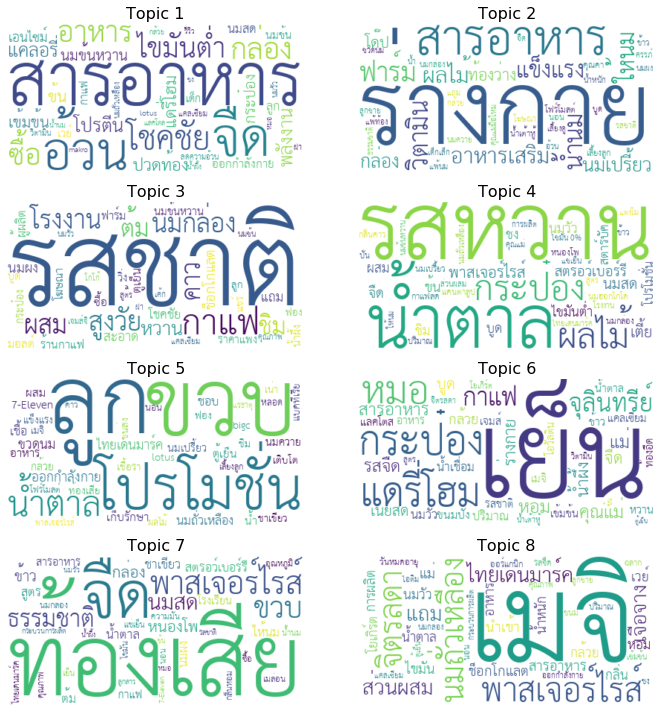

In [41]:
# REF: https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/

topics = model.show_topics(num_topics=model.num_topics, num_words=300,formatted=False)

th_stopwords = set(thai_stopwords())
minProb = 0.001
maxProb = 0.01

fig, axes = plt.subplots(4, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    try:
        fig.add_subplot(ax)
        topic_words = {a: b for a, b in topics[i][1] if a not in th_stopwords and (b >= minProb and b <= maxProb)}
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        plt.gca().imshow(cloud,interpolation='bilinear',cmap=plt.cm.gray)
        plt.gca().set_title('Topic ' + str(i+1), fontdict=dict(size=16))
        plt.gca().axis('off')
    except:
        print("An exception occurred")

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [42]:
topics = [[(term, round(wt, 3)) for term, wt in model.show_topic(n, topn=40)] for n in range(0, model.num_topics)]
# set column width
pd.set_option('display.max_colwidth', 1)
topics_df = pd.DataFrame([', '.join([term for term, wt in topic]) for topic in topics], columns = ['Terms per Topic'], index=['Topic'+str(t) for t in range(1, model.num_topics+1)] )
topics_df

,Terms per Topic
Topic1,"เมจิ, นม, ไขมัน, น้ำตาล, นมผง, ร่างกาย, โฆษณา, ผสม, รสชาติ, ท้องเสีย, น้ำ, โยเกิร์ต, bigc, หวาน, ปริมาณ, สูง, สูตร, ชอบ, แถม, นมเปรี้ยว, สารอาหาร, จืด, อ้วน, โชคชัย, กล่อง, อาหาร, ซื้อ, ไขมันต่ำ, แคลอรี่, พลังงาน, โปรตีน, ปวดท้อง, แดรี่โฮม, ข้น, เข้มข้น, กระป๋อง, นมข้นหวาน, เอนไซม์, นมสด, ลูก"
Topic2,"ลูก, แม่, นม, เด็ก, อาหาร, แคลเซียม, นมวัว, ชอบ, หมอ, นมถั่วเหลือง, ท้องเสีย, ขวบ, คุณแม่, เลี้ยง, แพ้นมวัว, แคลเซี่ยม, โปรตีน, ร่างกาย, สารอาหาร, สูง, ฟาร์ม, วิตามิน, น้ำนม, แข็งแรง, ให้นม, ผลไม้, อาหารเสริม, นมเปรี้ยว, กล่อง, ท้องว่าง, โด๊ป, น้ำเต้าหู้, นอน, คุณค่า, ข้าว, โฟร์โมสต์, เลี้ยงลูก, นมกล่อง, แพ้นม, น้ำ"
Topic3,"ไทยเดนมาร์ค, นม, หนองโพ, จิตรลดา, โยเกิร์ต, ชอบ, เมจิ, หอม, รสหวาน, นมสด, จืด, รสจืด, แดรี่โฮม, โฟร์โมสต์, เข้มข้น, ข้น, เด็ก, กล่อง, พาสเจอร์ไรส์, รสชาติ, กาแฟ, สูงวัย, ผสม, โรงงาน, คาว, นมกล่อง, ต้ม, ชิม, หวาน, นมผง, ช็อกโกแลต, แถม, สะอาด, โชคชัย, ตู้เย็น, ผู้ผลิต, ร้านกาแฟ, ฟาร์ม, โฆษณา, มอลต์"
Topic4,"กล่อง, นม, โฟร์โมสต์, เมจิ, ซื้อ, หวาน, รสชาติ, แพ็ค, กลิ่น, หอม, ฝา, 7-Eleven, ชอบ, น้ำ, เมจิโกลด์, หลอด, กาแฟ, ช็อกโกแลต, โยเกิร์ต, ตู้เย็น, รสจืด, น้ำผึ้ง, รสหวาน, น้ำตาล, กระป๋อง, ผลไม้, พาสเจอร์ไรส์, เตี้ย, นมสด, ข้น, สตรอว์เบอร์รี, จืด, ชง, ไขมันต่ำ, ชิม, นมวัว, บูด, ผสม, โปรโมชั่น, สตาร์บัค"
Topic5,"สูง, นม, ซื้อ, แม่, โรงเรียน, ชง, เด็ก, รสหวาน, ลูกสาว, ต้ม, นมวัว, โยเกิร์ต, กล่อง, การออกกำลังกาย, แจก, แช่เย็น, นมกล่อง, รสชาติ, แถม, นมผง, เย็น, ลูก, ขวบ, โปรโมชั่น, น้ำตาล, ออกกำลังกาย, ไทยเดนมาร์ค, ขวดนม, นมถั่วเหลือง, เชื้อ, ชอบ, ผสม, น้ำ, อาหาร, ตู้เย็น, เก็บรักษา, นมเปรี้ยว, 7-Eleven, กล้วย, นมควาย"
Topic6,"ชอบ, โชคชัย, นมกล่อง, ฟาร์ม, นม, นอน, นมผง, เด็ก, ผลไม้, ซื้อ, ลูก, ชง, กล่อง, หนองโพ, นมสด, ขวบ, นมข้น, น้ำนม, เย็น, กระป๋อง, แดรี่โฮม, หมอ, จุลินทรีย์, กาแฟ, สูง, คุณแม่, แม่, หอม, น้ำผึ้ง, สารอาหาร, รสจืด, ร่างกาย, จืด, บูด, เนยสด, กล้วย, น้ำเชื่อม, นมวัว, ปริมาณ, ขนมปัง"
Topic7,"นม, ลูก, เมจิ, ชอบ, แม่, หอม, รสจืด, หวาน, ผสม, หลอด, อ้วน, โยเกิร์ต, รสกาแฟ, เด็ก, โฟร์โมสต์, ไขมันต่ำ, น้ำ, ท้องเสีย, จืด, พาสเจอร์ไรส์, ขวบ, ธรรมชาติ, นมสด, หนองโพ, กล่อง, ข้าว, สตรอว์เบอร์รี, ให้นม, นมผง, ต้ม, สูตร, น้ำตาล, ชาเขียว, สารอาหาร, กาแฟ, โรงเรียน, อุณหภูมิ, ความมัน, นมกล่อง, นอน"
Topic8,"นม, นมสด, นมผง, โปรตีน, ซื้อ, ลูก, นมเปรี้ยว, กล่อง, จืด, สูตร, รสชาติ, ผสม, ชอบ, บูด, สูง, โฟร์โมสต์, น้ำ, กระป๋อง, เมจิ, พาสเจอร์ไรส์, นมถั่วเหลือง, จิตรลดา, ไทยเดนมาร์ค, ส่วนผสม, แถม, เจือจาง, ช็อกโกแลต, นำเข้า, แม่, ไขมัน, สารอาหาร, นมวัว, น้ำตาล, กล้วย, การผลิต, น้ำหนัก, หอม, โยเกิร์ต, เวย์, กลิ่น"
